# ANALYZE NACs

Since the DO NACs actually requires the QE calculations, it is rather expensive to re-run. So, lets do all the plotting here

In [1]:
import os
import sys

# Fisrt, we add the location of the library to test to the PYTHON path
if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
    

from libra_py import hpc_utils
from libra_py import data_read
from libra_py import data_outs
from libra_py import units
from libra_py import QE_methods
from libra_py.workflows.nbra import step2
#import libra_py.workflows.nbra.step2_analysis as step2a

import numpy as np
from matplotlib.mlab import griddata

import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator

Now, we can read the produced data files. We are going to read the time-series of the following 4 matrices: vibronic Hamiltonian, Hvib, transition dipole moment matrices for x, y, and z components of the dipole moment operator.

In [2]:
prms = { "data_dim": 40, 
         "active_space":range(0,40),
         "isnap": 0, "fsnap": 10         
       }

prms.update({"data_re_prefix" : "res/0_Hprime_", "data_re_suffix" : "x_re",
             "data_im_prefix" : "res/0_Hprime_", "data_im_suffix" : "x_im"})
Hprime_x = data_read.get_data(prms)

prms.update({"data_re_prefix" : "res/0_Hprime_", "data_re_suffix" : "y_re",
             "data_im_prefix" : "res/0_Hprime_", "data_im_suffix" : "y_im"})
Hprime_y = data_read.get_data(prms)

prms.update({"data_re_prefix" : "res/0_Hprime_", "data_re_suffix" : "z_re",
             "data_im_prefix" : "res/0_Hprime_", "data_im_suffix" : "z_im"})
Hprime_z = data_read.get_data(prms)

prms.update({"data_re_prefix" : "res/hvib_dia_", "data_re_suffix" : "_re",
             "data_im_prefix" : "res/hvib_dia_", "data_im_suffix" : "_im"})
Hvib = data_read.get_data(prms)

Now, lets use the matrices at the very first step to plot them as 2D maps. To do this, we first need to convert the data types to something that can be used with matplotlib. These functions also return the x and y axes for plotting. 

Also, we use the Hvib matrix to create an axis with energies, also converting the energies to eV.

In [3]:
x, y, Hvib_data_re = data_outs.show_matrix_pyplot(Hvib[0].real(), 0)
x, y, Hvib_data_im = data_outs.show_matrix_pyplot(Hvib[0].imag(), 0)

x, y, Hprime_x_data_re = data_outs.show_matrix_pyplot(Hprime_x[0].real(), 0)
x, y, Hprime_x_data_im = data_outs.show_matrix_pyplot(Hprime_x[0].imag(), 0)

x, y, Hprime_y_data_re = data_outs.show_matrix_pyplot(Hprime_y[0].real(), 0)
x, y, Hprime_y_data_im = data_outs.show_matrix_pyplot(Hprime_y[0].imag(), 0)

x, y, Hprime_z_data_re = data_outs.show_matrix_pyplot(Hprime_z[0].real(), 0)
x, y, Hprime_z_data_im = data_outs.show_matrix_pyplot(Hprime_z[0].imag(), 0)

# Energy axis in eV
e = []
sz = Hvib[0].num_of_cols
for i in xrange(sz):
    e.append(Hvib[0].get(i,i).real * units.au2ev)

Here is an auxiliary function for plotting given 2-D data, X, as 2D plot. There is a lot of non-trivial stuff going on here - for instance, our energies axis is not uniform, so we had to do some interpolation (re-sampling). 

In [4]:
def plot_map(ax, energy, X):
    
    colormap =  "plasma" # "Blues" # options: plasma, viridis, binary, hot, etc.
    
    npts = len(energy)
    
    emin = energy[0]
    emax = energy[npts-1]
    
    extent=(emin, emax, emin, emax)
    
    xs0, ys0, zs0 = [], [], []

    for i in xrange(npts):    
        for j in xrange(npts):
            xs0.append(energy[i])
            ys0.append(energy[j])
            zs0.append(X[i][j])

    N = 30j
    xs,ys = np.mgrid[extent[0]:extent[1]:N, extent[2]:extent[3]:N]
    zs = griddata(xs0, ys0, zs0,  xs, ys, interp="linear")

    #ax.xticks(energy, rotation=30)
    #ax.yticks(energy, rotation=30)    
    
    ax.xticks(rotation=30)
    ax.yticks(rotation=30)
            
    ax.imshow(zs.T, cmap=colormap, extent=extent, interpolation='Lanczos', origin='lower')
    ax.plot(xs0, ys0, "ro")
    ax.colorbar()

And now lets actually plot the H' and Hvib matrices with the x and y axes being actual energies

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.


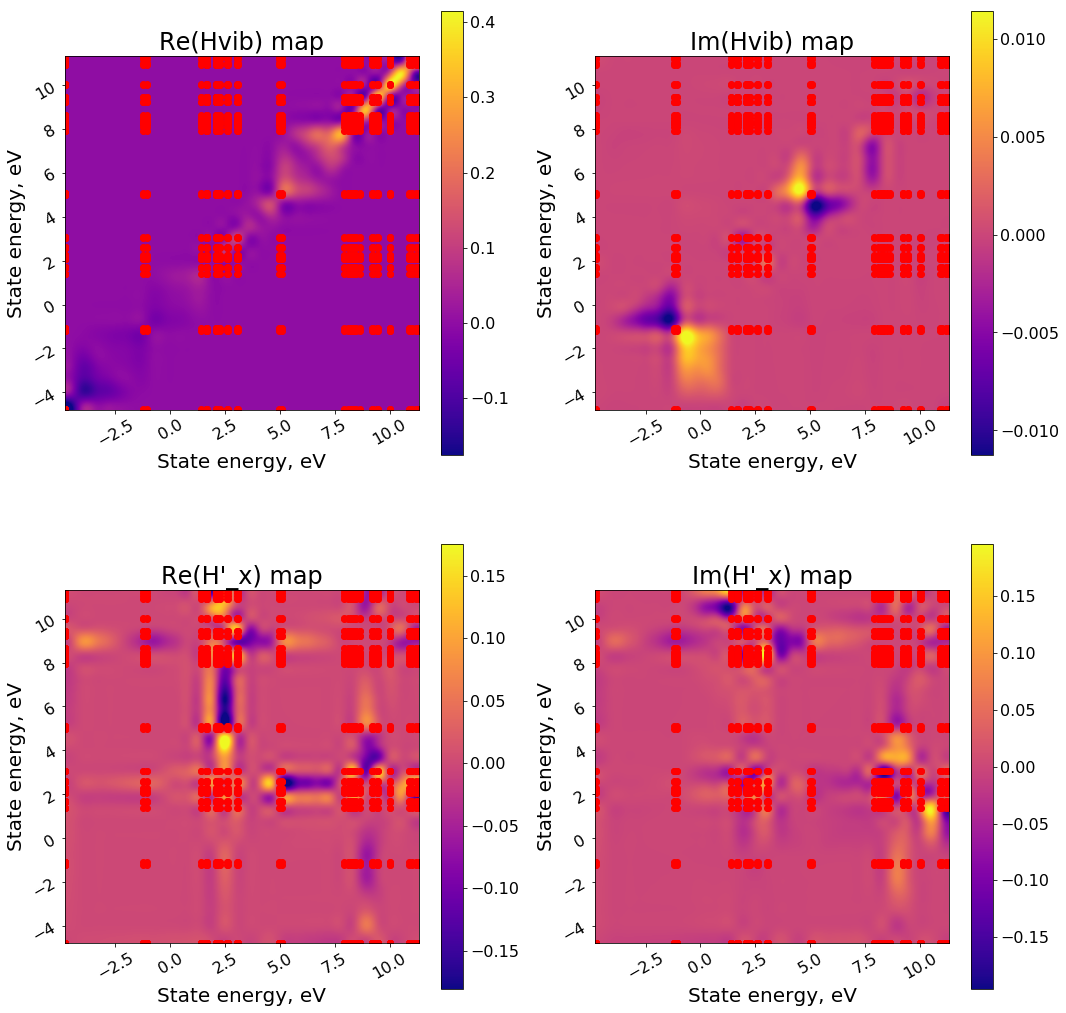

In [5]:
plt.figure(1, figsize=(18, 18)) # dpi=300, frameon=False)
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels


plt.subplot(2,2,1)
plt.title('Re(Hvib) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map(plt, e, Hvib_data_re)


plt.subplot(2,2,2)
plt.title('Im(Hvib) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map(plt, e, Hvib_data_im)


plt.subplot(2,2,3)
plt.title('Re(H\'_x) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map(plt, e, Hprime_x_data_re)

plt.subplot(2,2,4)
plt.title('Im(H\'_x) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map(plt, e, Hprime_x_data_im)


plt.show()
plt.close()

And here is the example of showing the same maps in the index space

In [14]:
def plot_map2(ax, x, y, Z):
    
    colormap =  "plasma" # "Blues" # options: plasma, viridis, binary, hot, etc.
    
    Nx = len(x)
    Ny = len(y)
    
    xmin = x[0]
    xmax = x[Nx-1]
    
    ymin = y[0]
    ymax = y[Ny-1]
    
    extent=(xmin, xmax, ymin, ymax)
                
    xs0, ys0, zs0 = [], [], []

    for i in xrange(Nx):    
        for j in xrange(Ny):
            xs0.append(x[i])
            ys0.append(y[j])
            zs0.append(Z[i][j])
    
    xs,ys = np.mgrid[xmin:xmax:Nx*1j, ymin:ymax:Ny*1j]
    zs = griddata(xs0, ys0, zs0,  xs, ys, interp="linear")

    #ax.xticks(energy, rotation=30)
    #ax.yticks(energy, rotation=30)    
    
    ax.xticks(rotation=30)
    ax.yticks(rotation=30)
            
    #ax.imshow(zs.T, cmap=colormap, extent=extent, interpolation='Lanczos', origin='lower')
    ax.imshow(zs.T, cmap=colormap, extent=extent, origin='lower')
    #ax.plot(xs0, ys0, "ro")
    ax.colorbar()
    

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.


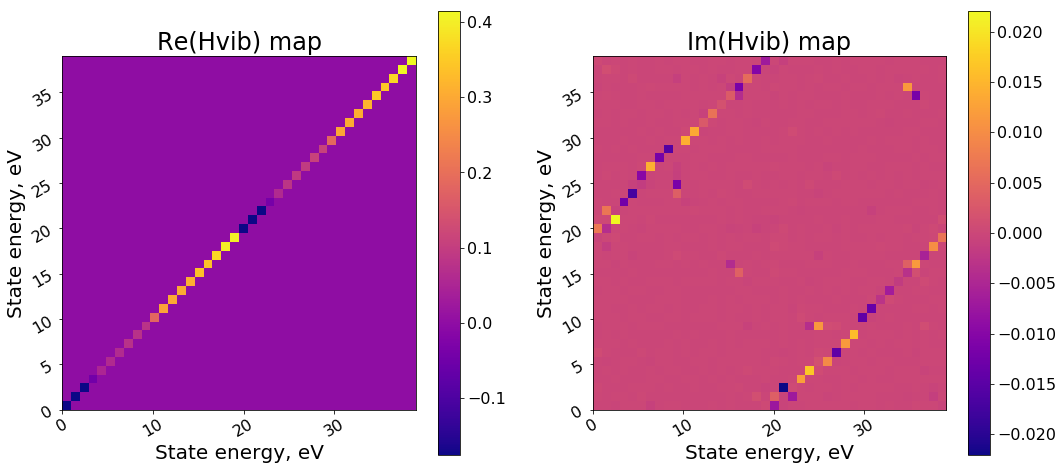

In [15]:
plt.figure(1, figsize=(18, 18)) # dpi=300, frameon=False)
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels


plt.subplot(2,2,1)
plt.title('Re(Hvib) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map2(plt, x, y, Hvib_data_re)

plt.subplot(2,2,2)
plt.title('Im(Hvib) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map2(plt, x, y, Hvib_data_im)